In [ ]:
from functools import wraps
from IPython.display import display, HTML, clear_output
from ipywidgets import *
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
from MCForecastTools import MCSimulation
import openai


%matplotlib inline

In [ ]:
load_dotenv()

True

In [5]:
# define the stocks
stocks = ['JPM', 'JNJ', 'MSFT', 'RIO', 'PFE']

# define the widgets for user input
stock_dropdown = Dropdown(options=stocks, description='Select a stock:', style={'description_width': 'initial', 'width': 'auto'})
weight_input = FloatText(description='Weight:', value=0.0)

# define the labels
selection_label = Label()
selected_stocks_label = Label(value='Selected stocks: ')
selected_weights_label = Label(value='Selected weights: ')

# define the function
selected_stocks = []
selected_weights = []

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)


def select_stock_and_weight(button):
    global selected_stocks, selected_weights
    # check max stocks are selected
    if len(selected_stocks) >= 3:
        selection_label.value = "Maximum of 3 stocks allowed"
        return
    # add the current selection to the list of stocks and weights
    selected_stock = stock_dropdown.value
    if selected_stock in selected_stocks:
        selection_label.value = "Cannot have duplicated stocks"
        return
    selected_weight = weight_input.value
    selected_stocks.append(selected_stock)
    selected_weights.append(selected_weight)
    # update the selection label
    selected_stocks_label.value += f'{selected_stock}, '
    selected_weights_label.value += f'{selected_weight}, '
    

def submit(button):
    global selected_stocks, selected_weights
    # check that the sum of weights is equal to 1
    total_weight = sum(selected_weights)
    if total_weight != 1:
        selection_label.value = "Weights must add up to 1"
        return
    # check max stocks are selected
    if len(selected_stocks) > 3:
        selection_label.value = "Please select Maximum three stocks"
        return
    # get the initial investment value
    initial_investment = initial_investment_input.value
    # create variables to hold the selected stocks, weights, and initial investment
    analysis_stocks = selected_stocks.copy()
    analysis_weights = selected_weights.copy()
    
    selected_stocks_label.value = 'Selected stocks: '
    selected_weights_label.value = 'Selected weights: '
    selection_label.value = "Selection submitted"
    
    
def clear(button):
    global selected_stocks, selected_weights
    selected_stocks = []
    selected_weights = []
    selection_label.value = ""
    selected_stocks_label.value = 'Selected stocks: '
    selected_weights_label.value = 'Selected weights: '
    stock_dropdown.value = stocks[0]
    weight_input.value = 0.0
    initial_investment_input.value = 0.0
    

# select and submit buttons
select_button = Button(description='Select')
select_button.on_click(select_stock_and_weight)
submit_button = Button(description='Submit')
submit_button.on_click(submit)
clear_button = Button(description='Clear')
clear_button.on_click(clear)


# create the widgets
initial_investment_label = Label(value='Enter initial investment:')
initial_investment_input = FloatText(value=0.0)
inputs = VBox([stock_dropdown, weight_input, select_button, selected_stocks_label, selected_weights_label, selection_label, initial_investment_label, initial_investment_input, submit_button, clear_button])
display(inputs)


inputs.layout.border = 'solid 8px'
inputs.layout.padding = '10px'
inputs.layout.margin = '10px'
inputs.layout.width = '50%'

In [6]:
#Input variables
stock_name1 = selected_stocks[0]
stock1_weight = selected_weights[0]

stock_name2 = selected_stocks[1]
stock2_weight = selected_weights[1]

stock_name3 = selected_stocks[2]
stock3_weight = selected_weights[2]

stock1_weight = float(stock1_weight)
stock2_weight = float(stock2_weight)
stock3_weight = float(stock3_weight)

weights = [stock1_weight, stock2_weight, stock3_weight]

In [7]:
# Format todays date as ISO format
start_date = pd.Timestamp("2018-05-07", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2023-05-07", tz="America/New_York").isoformat()

# Set the tickers
tickers = [stock_name1, stock_name2, stock_name3, 'SPY']

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices
df_portfolio = api.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

In [8]:
SPY = df_portfolio[df_portfolio['symbol']=='SPY'].drop('symbol', axis=1)
stock1 = df_portfolio[df_portfolio['symbol']== stock_name1].drop('symbol', axis=1)
stock2 = df_portfolio[df_portfolio['symbol']== stock_name2].drop('symbol', axis=1)
stock3 = df_portfolio[df_portfolio['symbol']== stock_name3].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
df_combined = pd.concat([stock1,stock2,stock3,SPY], axis=1, keys=[stock_name1,stock_name2,stock_name3,'SPY'])
df_combined

JPM                                       \
                             open      high      low   close    volume   
timestamp                                                                
2018-05-07 04:00:00+00:00  108.76  109.6800  108.360  109.37   9360321   
2018-05-08 04:00:00+00:00  109.53  111.3400  109.280  110.99  12543451   
2018-05-09 04:00:00+00:00  111.44  113.6400  111.030  113.41  11368094   
2018-05-10 04:00:00+00:00  113.19  114.4400  112.750  114.29   9159723   
2018-05-11 04:00:00+00:00  114.49  114.7300  113.670  113.86  10253045   
...                           ...       ...      ...     ...       ...   
2023-05-01 04:00:00+00:00  142.26  143.3700  140.830  141.20  20422963   
2023-05-02 04:00:00+00:00  141.40  142.4100  138.430  138.92  14117994   
2023-05-03 04:00:00+00:00  138.44  138.6687  135.760  135.98  12937158   
2023-05-04 04:00:00+00:00  134.96  135.7200  131.810  134.12  17089164   
2023-05-05 04:00:00+00:00  136.44  137.8800  135.912  136.74  11106638   

                                                       MSFT            \
                          trade_count        vwap      open      high   
timestamp                                                               
2018-05-07 04:00:00+00:00       63644  109.112860   95.1700   96.7100   
2018-05-08 04:00:00+00:00       82974  110.634988   95.8456   96.1600   
2018-05-09 04:00:00+00:00       77404  112.738976   96.0100   96.9700   
2018-05-10 04:00:00+00:00       64923  113.926070   97.3800   97.9500   
2018-05-11 04:00:00+00:00       66275  114.032989   97.8000   97.8700   
...                               ...         ...       ...       ...   
2023-05-01 04:00:00+00:00      225315  141.925916  306.9700  308.6000   
2023-05-02 04:00:00+00:00      178268  139.418115  307.7600  309.1800   
2023-05-03 04:00:00+00:00      156409  137.014310  306.6200  308.6100   
2023-05-04 04:00:00+00:00      204069  133.616646  306.2400  307.7626   
2023-05-05 04:00:00+00:00      128401  136.707656  305.7200  311.9700   

                                     ...      RIO                         \
                                low  ...   volume trade_count       vwap   
timestamp                            ...                                   
2018-05-07 04:00:00+00:00   95.1000  ...  1757539       15159  55.540887   
2018-05-08 04:00:00+00:00   95.0631  ...  2571313       18251  55.142862   
2018-05-09 04:00:00+00:00   95.0500  ...  3765947       23195  56.417918   
2018-05-10 04:00:00+00:00   97.0500  ...  2347167       12600  57.116391   
2018-05-11 04:00:00+00:00   97.0400  ...  2502919       17262  57.624718   
...                             ...  ...      ...         ...        ...   
2023-05-01 04:00:00+00:00  305.1500  ...  2583871       29548  63.416576   
2023-05-02 04:00:00+00:00  303.9100  ...  3883471       45991  61.885363   
2023-05-03 04:00:00+00:00  304.0900  ...  3271803       40450  62.326175   
2023-05-04 04:00:00+00:00  303.4000  ...  2931329       35602  61.614480   
2023-05-05 04:00:00+00:00  304.2700  ...  3297822       32857  63.354188   

                              SPY                                       \
                             open     high      low   close     volume   
timestamp                                                                
2018-05-07 04:00:00+00:00  266.89  268.020  266.110  266.92   56495099   
2018-05-08 04:00:00+00:00  266.50  267.325  265.150  266.89   67703408   
2018-05-09 04:00:00+00:00  267.68  269.865  267.090  269.47   59773310   
2018-05-10 04:00:00+00:00  270.34  272.390  270.220  272.00   72065572   
2018-05-11 04:00:00+00:00  272.16  273.150  271.580  272.64   59909145   
...                           ...      ...      ...     ...        ...   
2023-05-01 04:00:00+00:00  415.47  417.620  415.265  415.51   62135864   
2023-05-02 04:00:00+00:00  414.77  414.820  407.820  410.84  104017961   
2023-05-03 04:00:00+00:00  411.36  413.870  407.770  408.02   91577386   
2023-05-04 04:00:

In [11]:
# Pick close prices
spy_close_price = df_combined["SPY"]["close"].values[0]
stock1_close_price = df_combined[stock_name1]["close"].values[0]
stock2_close_price = df_combined[stock_name2]["close"].values[0]
stock3_close_price = df_combined[stock_name3]["close"].values[0]

# Print close prices
print(f"Current {stock_name1} closing price: ${stock1_close_price}")
print(f"Current {stock_name2} closing price: ${stock2_close_price}")
print(f"Current {stock_name3} closing price: ${stock3_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current JPM closing price: $109.37
Current MSFT closing price: $96.22
Current RIO closing price: $55.48
Current SPY closing price: $266.92


In [12]:
# Concatenate the ticker DataFrames
df_stock_data = pd.concat(
    [stock1['close'], stock2['close'], stock3['close'], SPY['close']], 
    axis=1, 
    keys=[stock_name1,stock_name2,stock_name3,'SPY']
)

# Display sample data
df_stock_data.head()

,JPM,MSFT,RIO,SPY
timestamp,,,,
2018-05-07 04:00:00+00:00,109.37,96.22,55.48,266.92
2018-05-08 04:00:00+00:00,110.99,95.81,55.41,266.89
2018-05-09 04:00:00+00:00,113.41,96.94,56.56,269.47
2018-05-10 04:00:00+00:00,114.29,97.91,57.35,272.00
2018-05-11 04:00:00+00:00,113.86,97.70,57.39,272.64


In [13]:
# Calculate daily returns for all portfolios
daily_returns = df_stock_data.pct_change().dropna().copy()
# Calculate portfolio return
stock_daily_returns = daily_returns.drop('SPY', axis=1)
stock_daily_returns.head()
portfolio_return = stock_daily_returns.dot(weights)
# Display sample data
portfolio_return.head()

timestamp
2018-05-08 04:00:00+00:00    0.002661
2018-05-09 04:00:00+00:00    0.018381
2018-05-10 04:00:00+00:00    0.010917
2018-05-11 04:00:00+00:00   -0.001493
2018-05-14 04:00:00+00:00    0.004325
dtype: float64

In [14]:
daily_returns["Custom Portfolio"] = portfolio_return
daily_returns.head()

,JPM,MSFT,RIO,SPY,Custom Portfolio
timestamp,,,,,
2018-05-08 04:00:00+00:00,0.014812,-0.004261,-0.001262,-0.000112,0.002661
2018-05-09 04:00:00+00:00,0.021804,0.011794,0.020754,0.009667,0.018381
2018-05-10 04:00:00+00:00,0.007759,0.010006,0.013967,0.009389,0.010917
2018-05-11 04:00:00+00:00,-0.003762,-0.002145,0.000697,0.002353,-0.001493
2018-05-14 04:00:00+00:00,0.000351,0.003378,0.008015,0.001137,0.004325


<AxesSubplot:ylabel='Frequency'>

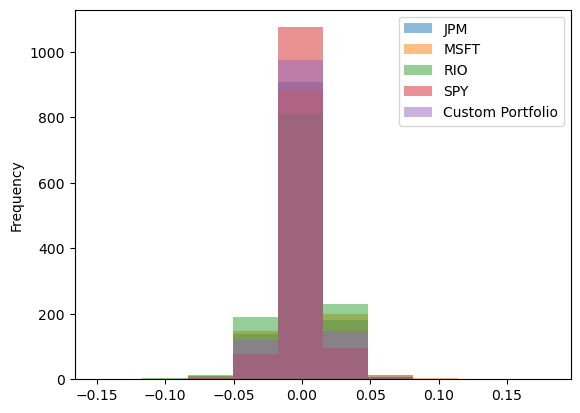

In [15]:
# Visualize the distribution of daily returns across all stocks using a histogram plot
daily_returns.plot.hist(alpha=0.5)

<AxesSubplot:ylabel='Density'>

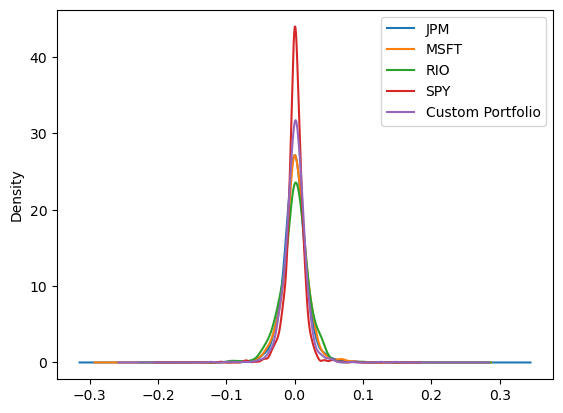

In [16]:
 # Visualize the distribution of daily returns across all stocks using a density plot
daily_returns.plot.density()

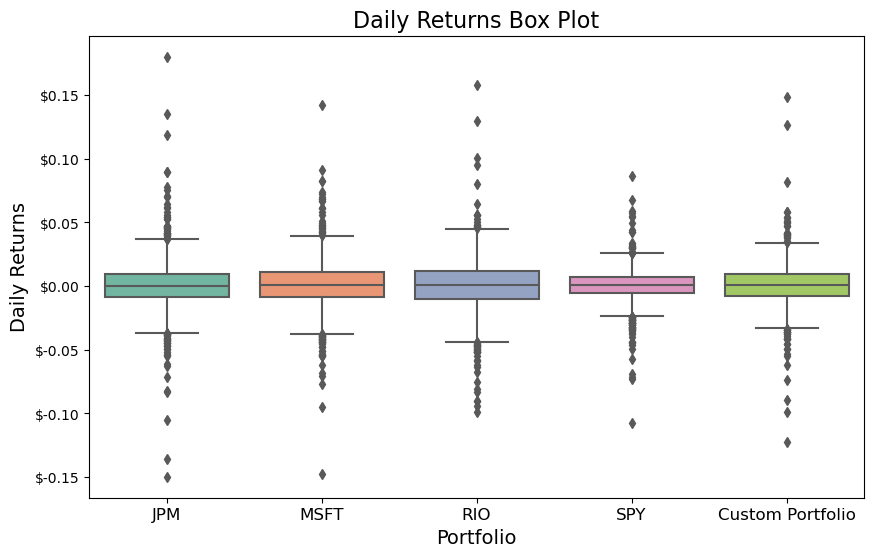

In [17]:
# Create box plot of daily returns for all portfolios

fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=daily_returns, palette="Set2")
ax.set_title('Daily Returns Box Plot', fontsize=16)
ax.set_xlabel('Portfolio', fontsize=14)
ax.set_ylabel('Daily Returns', fontsize=14)

plt.xticks(fontsize=12)
ax.yaxis.set_major_formatter('${x:,.2f}')

# Show the plot
plt.show()

<AxesSubplot:title={'center':'Daily Returns'}, xlabel='timestamp'>

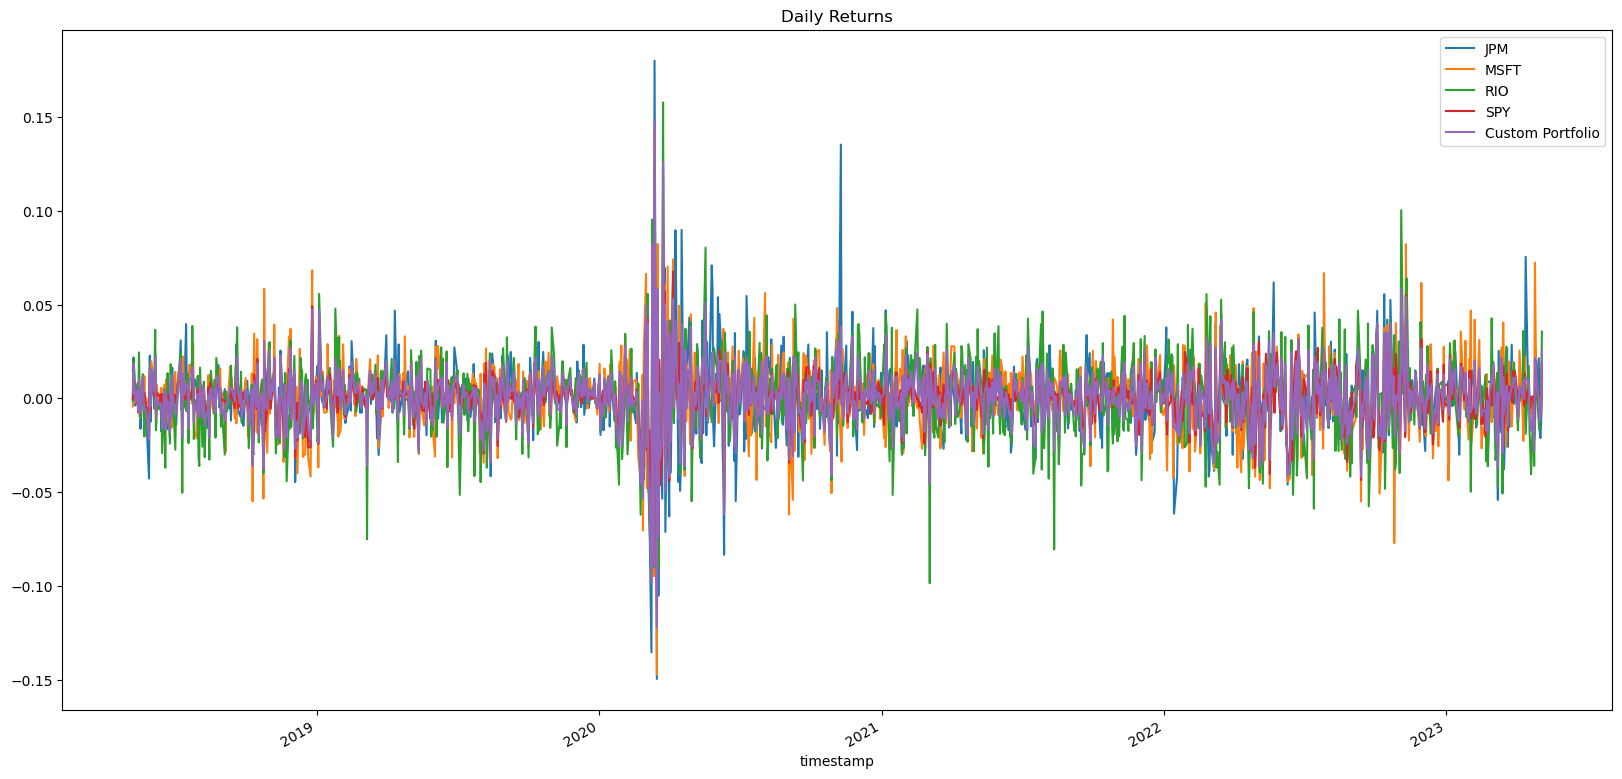

In [18]:
daily_returns.plot(figsize=(20, 10), title="Daily Returns")

In [20]:
# Calculate cumulative returns
cumulative_returns = (1 + daily_returns).cumprod() - 1
cumulative_returns

,JPM,MSFT,RIO,SPY,Custom Portfolio
timestamp,,,,,
2018-05-08 04:00:00+00:00,0.014812,-0.004261,-0.001262,-0.000112,0.002661
2018-05-09 04:00:00+00:00,0.036939,0.007483,0.019466,0.009553,0.021091
2018-05-10 04:00:00+00:00,0.044985,0.017564,0.033706,0.019032,0.032238
2018-05-11 04:00:00+00:00,0.041053,0.015381,0.034427,0.021430,0.030696
2018-05-14 04:00:00+00:00,0.041419,0.018811,0.042718,0.022591,0.035154
...,...,...,...,...,...
2023-05-01 04:00:00+00:00,0.291030,2.175639,0.138609,0.556684,0.766225
2023-05-02 04:00:00+00:00,0.270184,2.174080,0.119683,0.539188,0.745666
2023-05-03 04:00:00+00:00,0.243303,2.163583,0.117700,0.528623,0.731615


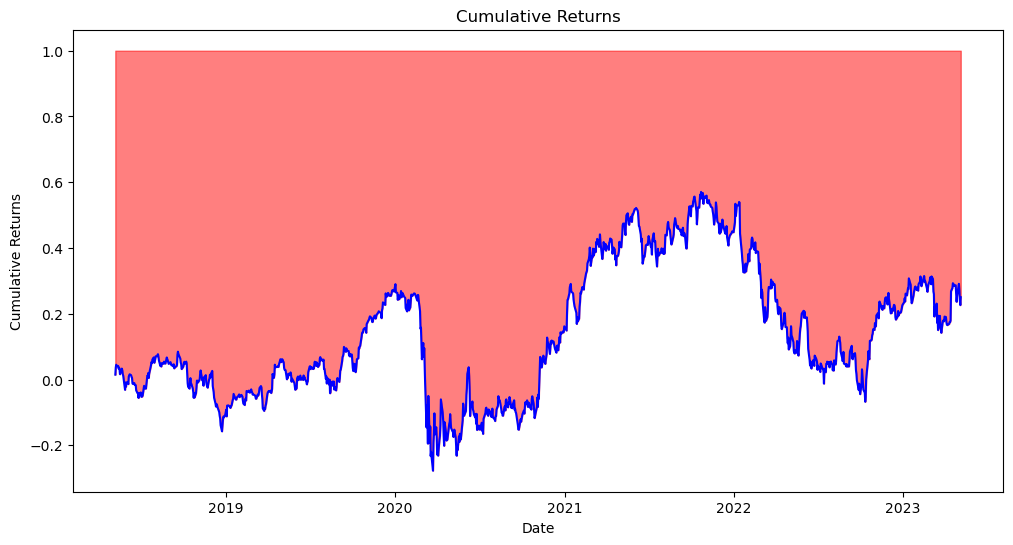

In [21]:
# plot cumulative returns
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(cumulative_returns.iloc[:,0], color='blue')

# fill above and below 1
ax.fill_between(cumulative_returns.index, cumulative_returns.iloc[:,0], 1, where=cumulative_returns.iloc[:,0]>=1, interpolate=True, color='green', alpha=0.5)
ax.fill_between(cumulative_returns.index, cumulative_returns.iloc[:,0], 1, where=cumulative_returns.iloc[:,0]<=1, interpolate=True, color='red', alpha=0.5)

# set plot title and axis labels
ax.set_title('Cumulative Returns')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')

# show plot
plt.show()

<AxesSubplot:title={'center':'Cumulative Returns'}, xlabel='timestamp'>

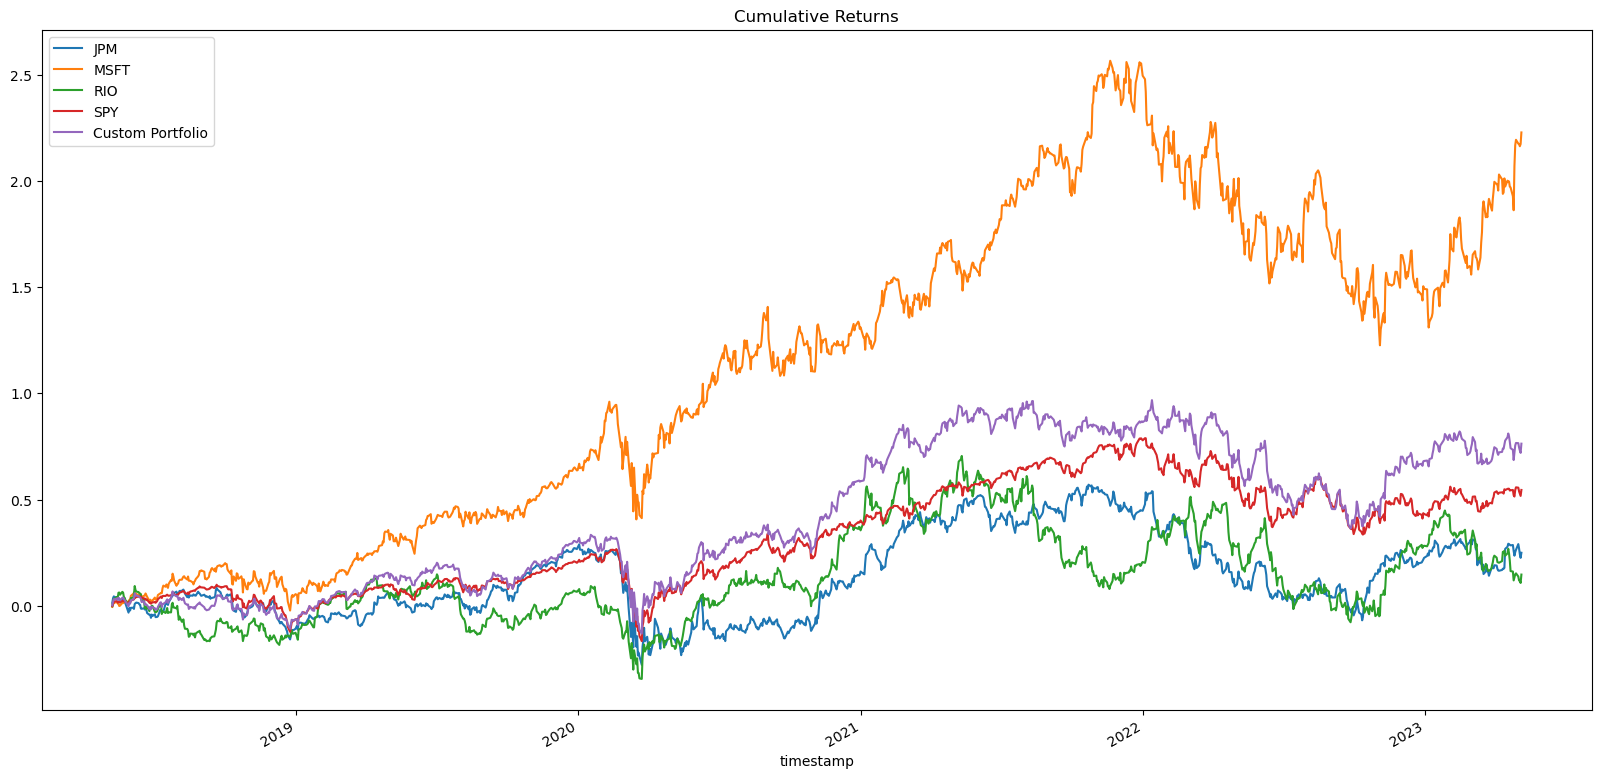

In [22]:
cumulative_returns.plot(figsize=(20, 10), title="Cumulative Returns")

In [23]:
# Calculate the daily standard deviations of all portfolios
daily_std = daily_returns.std()
stock1_std = daily_returns[stock_name1].std()
stock2_std = daily_returns[stock_name2].std()
stock3_std = daily_returns[stock_name3].std()
spy_stock = daily_returns['SPY'].std()
portfolio_std = daily_returns['Custom Portfolio'].std()
print("Daily Standard Deviation:")
print(daily_std)

# Calculate the annualised standard deviation 
annualised_std = daily_std * np.sqrt(252)
stock1_annualised_std = stock1_std * np.sqrt(252)
stock2_annualised_std = stock2_std * np.sqrt(252)
stock3_annualised_std = stock2_std * np.sqrt(252)
spy_annualised_std = spy_stock * np.sqrt(252)
portfolio_annualised_std = portfolio_std * np.sqrt(252)
print("Annualised Standard Deviation:")
print(annualised_std)


if stock1_annualised_std > spy_annualised_std and stock2_annualised_std > spy_annualised_std and stock3_annualised_std > spy_annualised_std:
    print("Based on the value of annualised standard deviations, all three stocks are riskier than the S&P 500 index.")
elif stock1_annualised_std > spy_annualised_std and stock2_annualised_std > spy_annualised_std:
    print(f"Based on the value of annualised standard deviations, {stock_name1} and {stock_name2} are riskier than the S&P 500 index.")
elif stock1_annualised_std > spy_annualised_std and stock3_annualised_std > spy_annualised_std:
    print(f"Based on the value of annualised standard deviations, {stock_name1} and {stock_name3} are riskier than the S&P 500 index.")
elif stock2_annualised_std > spy_annualised_std and stock3_annualised_std > spy_annualised_std:
    print(f"Based on the value of annualised standard deviations, {stock_name2} and {stock_name3} are riskier than the S&P 500 index.")
elif stock1_annualised_std > spy_annualised_std:
    print(f"Based on the value of annualised standard deviations, {stock_name1} is riskier than the S&P 500 index.")
elif stock2_annualised_std > spy_annualised_std:
    print(f"Based on the value of annualised standard deviations, {stock_name2} is riskier than the S&P 500 index.")
elif stock3_annualised_std > spy_annualised_std:
    print(f"Based on the value of annualised standard deviations, {stock_name3} is riskier than the S&P 500 index.")
else:
    print("Based on the value of annualised standard deviations, all three stocks are less risky than the S&P 500 index.")
    
if portfolio_annualised_std > spy_annualised_std:
    print("The custom portfolio is riskier than the market (SPY).")
else:
    print("The custom portfolio is less risky than the market (SPY).")

Daily Standard Deviation:
JPM                 0.020376
MSFT                0.019540
RIO                 0.021613
SPY                 0.013245
Custom Portfolio    0.016637
dtype: float64
Annualised Standard Deviation:
JPM                 0.323467
MSFT                0.310182
RIO                 0.343097
SPY                 0.210265
Custom Portfolio    0.264107
dtype: float64
Based on the value of annualised standard deviations, all three stocks are riskier than the S&P 500 index.
The custom portfolio is riskier than the market (SPY).


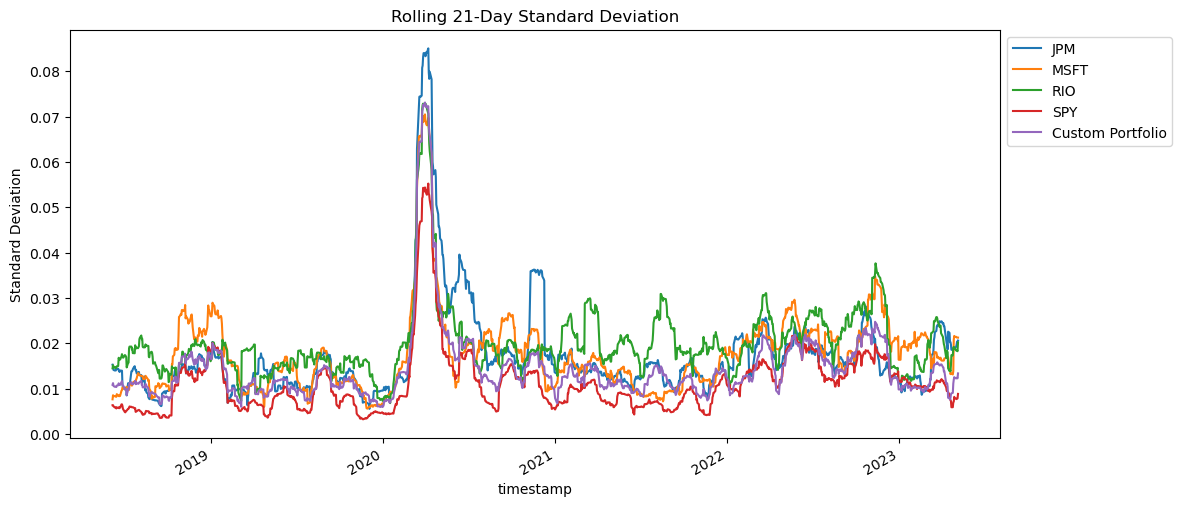

In [24]:
# Calculate the rolling standard deviation for all portfolios using a 21-day window
window_size = 21
rolling_std = daily_returns.rolling(window_size).std()

# Create figure and axes objects
fig, ax = plt.subplots(figsize=(12, 6))

# Set title, x-label, y-label, and grid
ax.set_title('Rolling 21-Day Standard Deviation')
ax.set_xlabel('Date')
ax.set_ylabel('Standard Deviation')
ax.grid(True)

# Plot the rolling standard deviation
rolling_std.plot(ax=ax)

# Add legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Show the plot
plt.show()

In [25]:
# Calculate correlation
correlation = daily_returns.corr()
correlation.style.background_gradient(cmap="bwr")

,JPM,MSFT,RIO,SPY,Custom Portfolio
JPM,1.000000,0.461278,0.530350,0.726937,0.805541
MSFT,0.461278,1.000000,0.406598,0.824464,0.733106
RIO,0.530350,0.406598,1.000000,0.570302,0.857759
SPY,0.726937,0.824464,0.570302,1.000000,0.853935
Custom Portfolio,0.805541,0.733106,0.857759,0.853935,1.000000


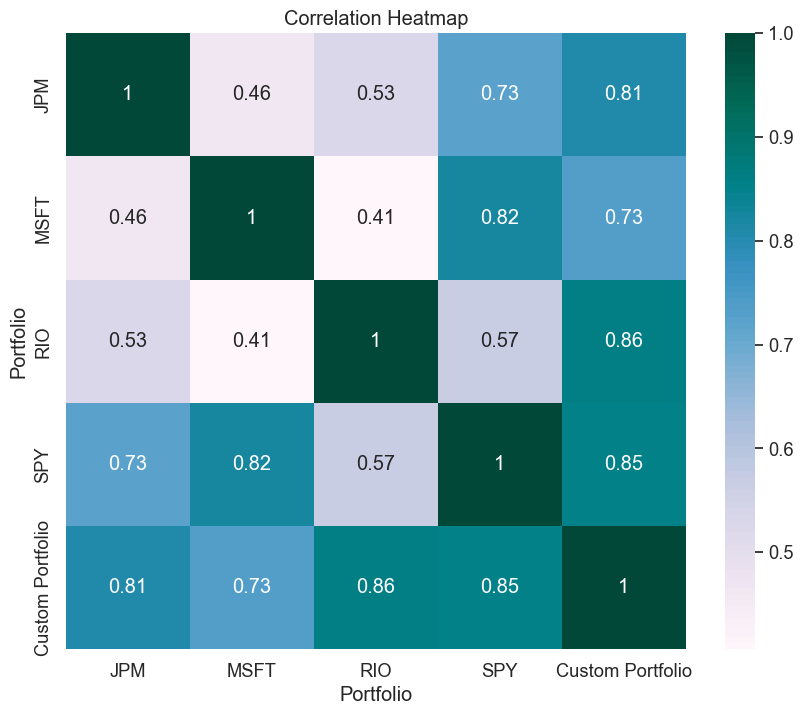

In [26]:
# Plot correlation matrix using heatmap
colors = sns.color_palette("PuBuGn", n_colors=100)

sns.set(font_scale=1.2)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap=colors)
plt.title("Correlation Heatmap")
plt.xlabel('Portfolio')
plt.ylabel('Portfolio')

# Show the plot
plt.show()

In [27]:
# Calculate beta
covariance_matrix = daily_returns.cov()

# JPM_beta = covariance_matrix.loc['JPM_2']['SPY_2'] / covariance_matrix.loc['SPY_2']['SPY_2']
# JNJ_beta = covariance_matrix.loc['JNJ_2']['SPY_2'] / covariance_matrix.loc['SPY_2']['SPY_2']
# MSFT_beta = covariance_matrix.loc['MSFT_2']['SPY_2'] / covariance_matrix.loc['SPY_2']['SPY_2']
# RIO_beta = covariance_matrix.loc['RIO_2']['SPY_2'] / covariance_matrix.loc['SPY_2']['SPY_2']
# PFE_beta = covariance_matrix.loc['PFE_2']['SPY_2'] / covariance_matrix.loc['SPY_2']['SPY_2']
stock1_beta = covariance_matrix.loc[stock_name1]['SPY'] / covariance_matrix.loc['SPY']['SPY']
stock2_beta = covariance_matrix.loc[stock_name2]['SPY'] / covariance_matrix.loc['SPY']['SPY']
stock3_beta = covariance_matrix.loc[stock_name3]['SPY'] / covariance_matrix.loc['SPY']['SPY']
portfolio_beta = covariance_matrix.loc['Custom Portfolio']['SPY'] / covariance_matrix.loc['SPY']['SPY']
spy_beta = covariance_matrix.loc['SPY']['SPY'] / covariance_matrix.loc['SPY']['SPY']

# print(f"JPM beta: {JPM_beta:.2f}")
# print(f"JNJ beta: {JNJ_beta:.2f}")
# print(f"MSFT beta: {MSFT_beta:.2f}")
# print(f"RIO beta: {RIO_beta:.2f}")
# print(f"PFE beta: {PFE_beta:.2f}")
print(f"{stock_name1} beta: {stock1_beta:.2f}")
if stock1_beta > spy_beta:
    print(f"{stock_name1} is more volatile than the overall market.")
elif stock1_beta < spy_beta:
    print(f"{stock_name1} is less volatile than the overall market.")
else:
    print(f"{stock_name1} has the same volatility as the overall market.")
print(f"{stock_name2} beta: {stock2_beta:.2f}")
if stock2_beta > spy_beta:
    print(f"{stock_name2} is more volatile than the overall market.")
elif stock2_beta < spy_beta:
    print(f"{stock_name2} is less volatile than the overall market.")
else:
    print(f"{stock_name2} has the same volatility as the overall market.")
print(f"{stock_name3} beta: {stock3_beta:.2f}")
if stock3_beta > spy_beta:
    print(f"{stock_name3} is more volatile than the overall market.")
elif stock3_beta < spy_beta:
    print(f"{stock_name3} is less volatile than the overall market.")
else:
    print(f"{stock_name3} has the same volatility as the overall market.")
print(f"Custom Portfolio beta: {portfolio_beta:.2f}")
if portfolio_beta > spy_beta:
    print(f"The custom portfolio is more volatile than the overall market.")
elif portfolio_beta < spy_beta:
    print(f"The custom portfolio is less volatile than the overall market.")
else:
    print(f"The custom portfolio has the same volatility as the overall market.")

JPM beta: 1.12
JPM is more volatile than the overall market.
MSFT beta: 1.22
MSFT is more volatile than the overall market.
RIO beta: 0.93
RIO is less volatile than the overall market.
Custom Portfolio beta: 1.07
The custom portfolio is more volatile than the overall market.


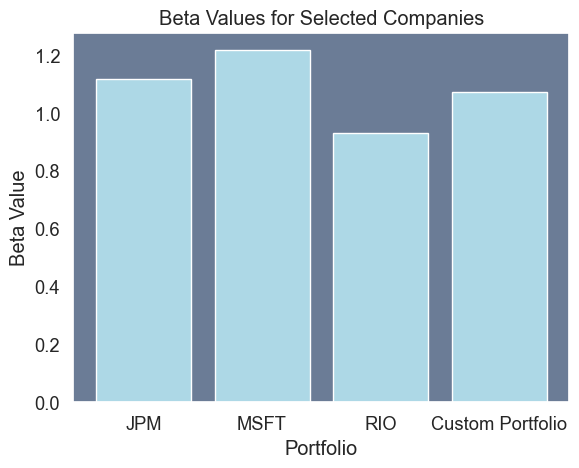

In [28]:
# Define beta values
beta_values = [stock1_beta,stock2_beta,stock3_beta,portfolio_beta]

# Define company names
company_names = [stock_name1, stock_name2, stock_name3, 'Custom Portfolio']

# Show the plot
colors = ['#ADD8E6']
plt.bar(company_names, beta_values, color=colors)
plt.title('Beta Values for Selected Companies')
plt.xlabel('Portfolio')
plt.ylabel('Beta Value')
plt.gca().set_facecolor('#6B7C96')
plt.grid(False)
plt.show()

In [31]:
# Sharpe Ratio
sharpe_ratio = (daily_returns.mean() * 252)/ (daily_returns.std() * np.sqrt(252))

# Set up OpenAI API key
openai.api_key = os.getenv("OPENAI_API_key")
# Convert the Sharpe ratio output to a string
sharpe_ratio_str = sharpe_ratio.to_string()

# Generate a summary using GPT-3
prompt = f"Please write a simple conclusion of the custom portfolio based on its Sharpe ratio. Provide a brief summary. \n\n{sharpe_ratio_str}"
response = openai.Completion.create(
    engine="text-davinci-002",
    prompt=prompt,
    max_tokens=100,
    n=1,
    stop=None,
    temperature=0.5,
)

# Print the summary generated by GPT-3
print(response.choices[0].text.strip())

The custom portfolio has a higher Sharpe ratio than the market portfolio, meaning that it has a higher return per unit of risk. This makes it a good choice for investors who are looking to maximize returns while minimizing risk.


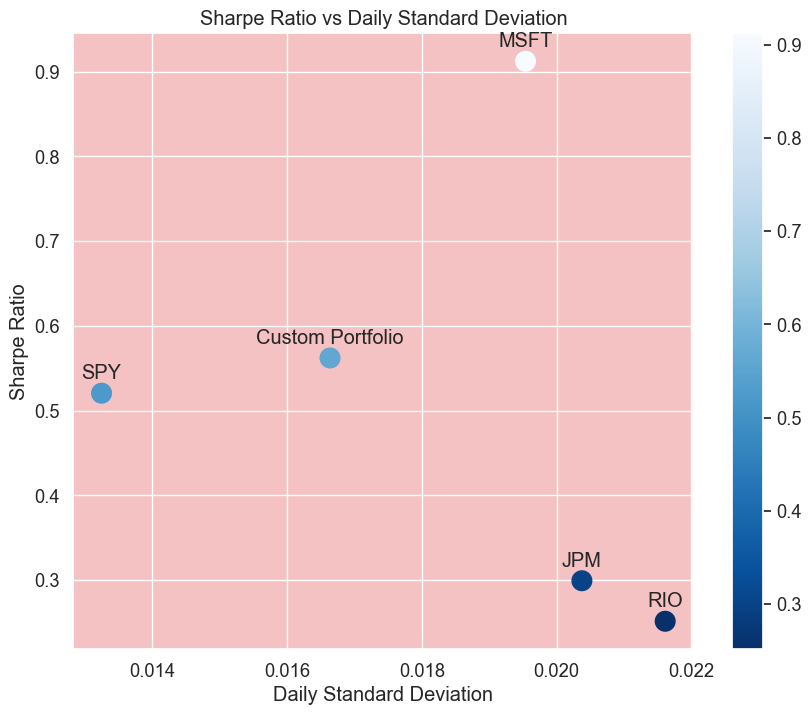

In [32]:
# Visualize the sharpe ratio vs Daily Standard Deviation
tickers = [stock_name1, stock_name2, stock_name3, 'SPY', 'Custom Portfolio']
sharpe_ratios = [sharpe_ratio[0], sharpe_ratio[1], sharpe_ratio[2], sharpe_ratio[3], sharpe_ratio[4]]
daily_std = [stock1_std, stock2_std, stock3_std, spy_stock, portfolio_std]
# Scatter plot with Sharpe ratios as color chart
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(daily_std, sharpe_ratios, c=sharpe_ratios, cmap='Blues_r', s=200)
ax.set_xlabel('Daily Standard Deviation')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio vs Daily Standard Deviation')
ax.set_facecolor('#F4C2C2')
# Add color bar
cbar = fig.colorbar(scatter)
cbar.set_label
# Add ticker labels to points
for i, ticker in enumerate(tickers):
    ax.annotate(ticker, (daily_std[i], sharpe_ratios[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()

In [35]:
df_stock_combined = pd.concat([stock1,stock2,stock3], axis=1, keys=[stock_name1,stock_name2,stock_name3])

MC_ten_year = MCSimulation(
    portfolio_data = df_stock_combined,
    weights = weights,
    num_simulation = 500,
    num_trading_days = 252 * 10
)

# Run a Monte Carlo simulation to forecast ten years cumulative returns
MC_ten_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\boris\finTech\project_1\Project_1\code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.013867,0.966630,1.001447,0.993462,0.987999,0.995897,1.000983,1.012506,0.982430,0.992174,...,1.005600,1.007158,0.998162,0.978460,1.025593,0.979817,1.015487,1.009103,1.014191,1.024775
2,0.996839,0.984387,1.017294,1.010020,0.997868,0.999934,1.008149,1.012173,0.951526,1.011511,...,1.011636,1.019269,1.005068,0.961865,1.020617,0.989468,0.995453,1.010991,1.027173,1.033349
3,0.997038,0.971671,1.042536,1.001143,1.005352,1.003521,1.000583,1.009807,0.959432,1.006567,...,1.020114,1.017059,0.997974,0.967798,1.008879,1.003814,0.991506,1.026122,1.028026,1.022705
4,0.991378,0.991971,1.033398,0.992848,1.002023,1.007697,1.004931,1.013150,0.961958,0.995627,...,1.035215,1.013342,0.980963,0.954527,1.013573,1.002590,0.957387,1.012981,1.037352,1.019245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.840045,2.350466,2.325730,2.439198,3.969941,6.754096,5.869049,3.449899,6.027665,6.775330,...,4.539513,4.653970,4.030700,2.852254,2.211010,4.448028,7.792625,1.742543,8.378248,0.834882
2517,2.815335,2.373248,2.330374,2.397589,3.939578,6.717451,5.727752,3.486179,6.089022,6.888991,...,4.508344,4.580889,4.106270,2.880843,2.180183,4.412389,7.862979,1.740067,8.434967,0.831041
2518,2.780228,2.473829,2.370982,2.387906,3.988247,6.690054,5.764542,3.483390,6.032105,7.050251,...,4.463612,4.655174,4.132597,2.861768,2.196289,4.400357,7.827821,1.732045,8.380620,0.832491
2519,2.766841,2.450143,2.371606,2.363849,3.986759,6.691636,5.729472,3.500541,6.025385,6.814709,...,4.429371,4.632623,4.133185,2.848811,2.179414,4.465404,7.924520,1.750238,8.307342,0.825604


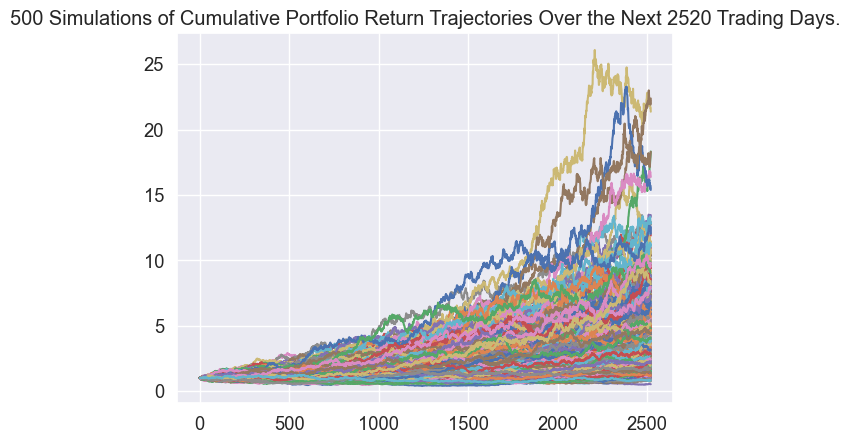

In [37]:
line_plot_five = MC_ten_year.plot_simulation()

In [38]:
simulated_returns_data = {
    "mean": list(MC_ten_year.simulated_return.mean(axis=1)),
    "median": list(MC_ten_year.simulated_return.median(axis=1)),
    "min": list(MC_ten_year.simulated_return.min(axis=1)),
    "max": list(MC_ten_year.simulated_return.max(axis=1))
}
# Create a DataFrame with the summary statistics
df_simulated_returns = pd.DataFrame(simulated_returns_data)

# Display sample data
df_simulated_returns.head()

,mean,median,min,max
0,1.000000,1.000000,1.000000,1.000000
1,0.999855,1.000187,0.962806,1.040901
2,0.999864,0.999705,0.951526,1.052390
3,0.999790,0.999840,0.945770,1.062141
4,1.001165,1.001572,0.931985,1.075291


In [40]:
# Multiply an initial investment by the daily returns of simulative stock prices to return the progression of daily returns in terms of money
cumulative_pnl = initial_investment_input.value * df_simulated_returns
cumulative_pnl

,mean,median,min,max
0,50000.000000,50000.000000,50000.000000,5.000000e+04
1,49992.738015,50009.352363,48140.307894,5.204505e+04
2,49993.193615,49985.269884,47576.282363,5.261952e+04
3,49989.481493,49991.993072,47288.502152,5.310705e+04
4,50058.255023,50078.599563,46599.228106,5.376454e+04
...,...,...,...,...
2516,217399.969114,185892.529099,27840.589805,1.113504e+06
2517,217467.622457,185232.659392,27635.048247,1.105881e+06
2518,217535.870202,185497.203982,27695.436144,1.095381e+06
2519,217635.120492,186006.625542,27602.009451,1.105817e+06


In [41]:
 # Fetch summary statistics from the Monte Carlo simulation results
# Hint: Use the `summarize_cumulative_return` function
tbl = MC_ten_year.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              4.351767
std               2.885944
min               0.544410
25%               2.388740
50%               3.707645
75%               5.409063
max              22.378135
95% CI Lower      1.052309
95% CI Upper     11.324703
Name: 2520, dtype: float64


In [42]:
 # Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $10,000 investments in TSLA stocks
ci_lower = round(tbl[8]*10000,2)
ci_upper = round(tbl[9]*10000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
      f" over the next year will end within in the range of"
      f" ${ci_lower} and ${ci_upper}.")

There is a 95% chance that an initial investment of $10,000 in the portfolio over the next year will end within in the range of $10523.09 and $113247.03.


In [44]:
# Define the prompt to be used to generate the board information
prompt = f"Please briefly summarize what is the main products or service of {stock_name1}, {stock_name2} and {stock_name3} and what they are working on"

# Specify the language model to be used for the request
model = "text-davinci-002"

# Generate the board information using the OpenAI API
response = openai.Completion.create(
    engine=model,
    prompt=prompt,
    max_tokens=1024,
    n=1,
    stop=None,
    temperature=0.5,
)

# Extract the generated text from the API response
board_info = response.choices[0].text.strip()
# Split the string into three paragraphs
paragraphs = board_info.split('\n\n\n')

# Print each paragraph
for i, paragraph in enumerate(paragraphs):
    print("Brief summary of the 3 companies you picked:")
    print(paragraph)
    print()

Brief summary of the 3 companies you picked:
JPM: JPMorgan Chase & Co. is a leading global financial services firm with assets of $2.6 trillion and operations worldwide. The firm is a leader in investment banking, financial services for consumers and businesses, financial transaction processing, asset management and private equity.

MSFT: Microsoft Corporation is the world's largest software company, with products that include the Windows operating system, the Office suite of productivity software, the Xbox game console, and the Bing search engine. Microsoft is also working on developing new products and services, such as the Windows Phone 7 operating system, the Azure cloud computing platform, and the Kinect motion-sensing device for the Xbox 360.

RIO: Rio Tinto is a leading international mining group that focuses on finding, mining and processing the Earth's mineral resources. Rio Tinto's main products are aluminum, copper, diamonds, gold, industrial minerals (borax, titanium dioxid